# ODE Modeling of Neuroblast Lineage Growth

In [ ]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Font size settings for figures
mpl.rcParams.update({
    "font.size": 14,              # base font size
    "axes.titlesize": 16,         # title font
    "axes.labelsize": 14,         # x/y label font
    "xtick.labelsize": 12,        # x-tick labels
    "ytick.labelsize": 12,        # y-tick labels
    "legend.fontsize": 12,        # legend text
    "lines.linewidth": 2,         # line thickness
    "axes.linewidth": 1.2,        # axis border thickness
})

# Function to make annotating data on figures easier
def annotate_final_values(ax, x, y_values, labels, min_sep_frac=0.1):
    """
    Adds annotations at the final time point of each y-series with spacing done in axis-fraction units.

    Parameters:
        ax: matplotlib Axes object
        x: time points (1D array)
        y_values: list of y-arrays
        labels: list of label strings
        min_sep_frac: minimum spacing between annotations in axis fraction (0.03 = 3% of y-axis height)
    """
    final_x = x[-1]
    final_ys = [y[-1] for y in y_values]
    y_min, y_max = ax.get_ylim()

    # Convert y-values to axis-fraction space
    y_fracs = [(y - y_min) / (y_max - y_min) for y in final_ys]

    # Sort and apply minimum spacing in axis-fraction space
    sorted_indices = np.argsort(y_fracs)
    new_frac_positions = {}
    last_frac = None
    for idx in sorted_indices:
        frac = y_fracs[idx]
        if last_frac is None:
            new_frac_positions[idx] = frac
        else:
            new_frac_positions[idx] = max(frac, last_frac + min_sep_frac)
        last_frac = new_frac_positions[idx]

    # Clamp to [0,1] and convert back to data coordinates
    for idx in range(len(y_values)):
        orig_y = final_ys[idx]
        frac_y = min(new_frac_positions[idx], 0.98)  # avoid going out of bounds
        adjusted_y = y_min + frac_y * (y_max - y_min)

        ax.annotate(f"{labels[idx]}\n{orig_y:.0f}",
                    xy=(final_x, orig_y),
                    xytext=(final_x + 1, adjusted_y),
                    textcoords='data',
                    fontsize=8,
                    va='center',
                    ha='left',
                    arrowprops=dict(arrowstyle='->', lw=0.5),
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", lw=0.5))

## 1. Modeling Cell Counts

This is a simple ODE model of that tracks the counts of each cell type in the developing neuroblast lineage. This model does not track cell volume and assumes homogeneous behavior within each cell type.

### Model Species
- **$N_{\text{NB}}$** - Number of neuroblasts, neuroblasts are stem-like cells that can divide asymmetrically yielding one neuroblast and one GMC or symmetrically yielding two neuroblasts
- **$N_{\text{GMC}}$** - Number of GMCs, Ganglion Mother Cells are neuron precursors that divide symmetrically into two neurons
- **$N_{\text{ImNeuron}}$** - Number of immature neurons. Immature neurons are terminally differentiated brain cells that do not grow nor divide. they mature into MatNeurons
- **$N_{\text{MatNeuron}}$** - Number of mature neurons. Mature neurons are terminally differentiated brain cells that do not grow, divide, nor change state.

### Model Parameters
- **$k_{\text{NB}}$** - the rate of neuroblast divisions, in units of divisions/hour
- **$k_{\text{GMC}}$** - the rate of GMC divisions, in units of divisions/hour
- **$k_{\text{Neuron}}$** — Rate at which immature neurons mature into mature neurons (transitions/hour).
- **$\text{sym\_frac}$** - the fraction of neuroblast divisions that are symmetrical. Unitless.
  - Set to 0 for WT simulations and .15 for mudmut simulations

### Model Structure
The number of neuroblasts increases by 1 with each symmetric neuroblast division
$$\frac{dN_{\text{NB}}}{dt} = \text{sym\_frac} * k_{\text{NB}} * N_{\text{NB}}$$

The number of GMCs increases by 1 with each asymmetric neuroblast division and decreases by 1 with each GMC division.
$$\frac{dN_{\text{GMC}}}{dt} = (1 - \text{sym\_frac}) \cdot k_{\text{NB}} N_{\text{NB}} - k_{\text{GMC}} N_{\text{GMC}}$$

Immature neurons increase by 2 per GMC division and decrease as they mature:
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2 \cdot k_{\text{GMC}} \cdot N_{\text{GMC}} - k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

Mature neurons increase as immature neurons mature:
$$
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

### Model Limitations
- This model assumes homogeneous populations of neuroblasts, GMCs, and neurons, meaning that all cells within each type behave identically. It does not account for variability in growth rates, cell cycle timing, cell volume, or stochasticity in fate decisions
- This model treats the rates of division as constant over time and independent of population size or environmental feedback
- This model does not track cell volumes

In [ ]:
def neuroblast_model(t, y, params):
    N_NB, N_GMC, N_ImNeuron, N_MatNeuron = y
    k_NB, k_GMC, k_Neuron, sym_frac = params  # Division and maturation rates

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # ODEs
    dN_NB = sym_divs
    dN_GMC = asym_divs - k_GMC * N_GMC
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dN_MatNeuron = k_Neuron * N_ImNeuron

    return [dN_NB, dN_GMC, dN_ImNeuron, dN_MatNeuron]

### WT Simulation
**Parameter Justifications**
- Neuroblast division date - 1 division per 1.5 hours, from literature
- GMC division rate - 1 division per 9 hours, from literature
- Neuron maturation rate - 1 maturation per 48 hours, calibrated to allow WT lineages to have an average of 42 visable cells by the end of 48 hours

In [ ]:
# Parameter value assignment
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,    # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.0      # 0% symmetric NB divisions for WT
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

### mudmut Simulation
**Parameter Justifications**
I left all the parameters the same as the WT simulation except changed the percent symmetric divisions to .15.

In [ ]:
# Parameter value assignment
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,   # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.15      # 15% symmetric NB divisions for mudmut
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

### Conclusion from simple cell count model:
- ODE modling of cell growth and division behavior yields mud colonies with many more cells than wt colonies, which is the opposite of what is observed experimentally

# 2. NB Division Repressed by GMC Count: Simple Count Model

In this simplified model, **neuroblast (NB) division** is down-regulated by the **number of GMCs**. GMC division and neuron maturation proceed at fixed rates. This isolates how the size of the GMC pool can feed back onto NB self-renewal.

### Model Species
- **$N_{\text{NB}}$** — Neuroblasts  
- **$N_{\text{GMC}}$** — Ganglion Mother Cells  
- **$N_{\text{ImNeuron}}$** — Immature neurons  
- **$N_{\text{MatNeuron}}$** — Mature neurons

### Parameters
- **$k_{\text{NB,max}}$** — Max NB division rate (1/hr)  
- **$k_{\text{GMC}}$** — GMC division rate (1/hr)  
- **$k_{\text{Neuron}}$** — Immature neuron maturation rate (1/hr)  
- **$K_{\text{GMC}\to\text{NB}},\, n_{\text{gmc}}$** — Half-max constant & Hill coefficient for **GMC-mediated repression of NB division**  
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless)

### Feedback (GMC → NB repression)
$$
k_{\text{NB,eff}} \;=\; k_{\text{NB,max}} \cdot
\frac{K_{\text{GMC}\to\text{NB}}^{\,n_{\text{gmc}}}}
     {K_{\text{GMC}\to\text{NB}}^{\,n_{\text{gmc}}} + N_{\text{GMC}}^{\,n_{\text{gmc}}}}
$$

### ODEs
$$
\text{sym\_divs} = \text{sym\_frac}\,k_{\text{NB,eff}}\,N_{\text{NB}},\qquad
\text{asym\_divs} = (1-\text{sym\_frac})\,k_{\text{NB,eff}}\,N_{\text{NB}}.
$$
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs},\qquad
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC}}\,N_{\text{GMC}},
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2\,k_{\text{GMC}}\,N_{\text{GMC}} - k_{\text{Neuron}}\,N_{\text{ImNeuron}},\qquad
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}}\,N_{\text{ImNeuron}}.
$$

**Notes:**
- Set $n_{\text{gmc}}=1$ for Michaelis–Menten–like repression; larger $n_{\text{gmc}}$ yields a sharper, switch-like response.  
- Larger $K_{\text{GMC}\to\text{NB}}$ weakens repression (requires more GMCs to inhibit NB division).

In [ ]:
def neuroblast_model_GMC_represses_NB_count(t, y, params):
    """
    Simple count model where GMC abundance represses NB division rate.

    State vector:
        y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]

    Parameters (in order):
        k_NB_max      : float   # maximum NB division rate (1/hr)
        k_GMC         : float   # GMC division rate (1/hr)
        k_Neuron      : float   # immature neuron maturation rate (1/hr)
        K_GMC_to_NB   : float   # half-max constant for GMC -> NB repression (cells)
        n_gmc         : float   # Hill coefficient for GMC -> NB repression
        sym_frac      : float   # fraction of NB divisions that are symmetric (unitless)

    ODEs:
        sym_divs  = sym_frac * k_NB_eff * N_NB
        asym_divs = (1 - sym_frac) * k_NB_eff * N_NB

        dN_NB        = sym_divs
        dN_GMC       = asym_divs - k_GMC * N_GMC
        dN_ImNeuron  = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
        dN_MatNeuron = k_Neuron * N_ImNeuron
    """
    N_NB, N_GMC, N_ImNeuron, N_MatNeuron = y
    k_NB_max, k_GMC, k_Neuron, K_GMC_to_NB, n_gmc, sym_frac = params

    # Guard against negatives / zeros in Hill terms
    N_GMC_pos = max(N_GMC, 0.0)
    K_pos     = max(K_GMC_to_NB, 1e-12)
    n_pos     = max(n_gmc, 1e-12)

    # GMC → NB repression (decreasing Hill)
    k_NB_eff = k_NB_max * (K_pos**n_pos) / (K_pos**n_pos + N_GMC_pos**n_pos)

    # Partition NB divisions
    sym_divs  = sym_frac * k_NB_eff * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB_eff * N_NB

    # ODEs
    dN_NB        = sym_divs
    dN_GMC       = asym_divs - k_GMC * N_GMC
    dN_ImNeuron  = 2.0 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dN_MatNeuron = k_Neuron * N_ImNeuron

    return [dN_NB, dN_GMC, dN_ImNeuron, dN_MatNeuron]

## WT

In [ ]:
# --- Parameters consistent with earlier choices ---
k_NB_max    = 1/.5     # max NB division rate: 1 per 30 mins
k_GMC       = 1/9.0    # avg GMC divides every ~9 h
k_Neuron    = 1/48.0   # avg neuron maturation ~48 h
K_GMC_to_NB = 2.0      # half-max GMC count for repression
n_gmc       = 1        # MM-like repression
sym_frac    = 0.0      # WT: asymmetric

params = [k_NB_max, k_GMC, k_Neuron, K_GMC_to_NB, n_gmc, sym_frac]

# --- Initial condition and integration grid ---
y0 = [1, 0, 0, 0]   # start with 1 NB, no other cells
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_GMC_represses_NB_count,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# --- Plot cell counts ---
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # optional helper
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT: NB division repressed by GMC count")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# --- Visualize k_NB_eff over time ---
N_GMC = sol.y[1]
if K_GMC_to_NB > 0:
    k_NB_eff = k_NB_max * (K_GMC_to_NB**n_gmc) / (K_GMC_to_NB**n_gmc + N_GMC**n_gmc)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_GMC)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under GMC-mediated repression")
ax.grid()
plt.tight_layout()
plt.show()

# --- Visualize NB cell cycle duration over time ---
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under GMC-mediated repression")
ax.grid()
plt.tight_layout()
plt.show()

## mudmut

In [ ]:
# --- Parameters consistent with earlier choices ---
k_NB_max    = 1/.5     # max NB division rate: 1 per 30 mins
k_GMC       = 1/9.0    # avg GMC divides every ~9 h
k_Neuron    = 1/48.0   # avg neuron maturation ~48 h
K_GMC_to_NB = 2.0      # half-max GMC count for repression
n_gmc       = 1        # mm-like repression
sym_frac    = 0.15     # mudmut

params = [k_NB_max, k_GMC, k_Neuron, K_GMC_to_NB, n_gmc, sym_frac]

# --- Initial condition and integration grid ---
y0 = [1, 0, 0, 0]   # start with 1 NB, no other cells
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_GMC_represses_NB_count,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# --- Plot cell counts ---
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # optional helper
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT: NB division repressed by GMC count")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# --- Visualize k_NB_eff over time ---
N_GMC = sol.y[1]
if K_GMC_to_NB > 0:
    k_NB_eff = k_NB_max * (K_GMC_to_NB**n_gmc) / (K_GMC_to_NB**n_gmc + N_GMC**n_gmc)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_GMC)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under GMC-mediated repression")
ax.grid()
plt.tight_layout()
plt.show()

# --- Visualize NB cell cycle duration over time ---
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under GMC-mediated repression")
ax.grid()
plt.tight_layout()
plt.show()

---

## 3. NB Self‑Repression Only: Simple Count Model

In this simplified model, only **neuroblast (NB) division** is down‑regulated by the **number of NBs**. GMC division and neuron maturation proceed at fixed rates. This isolates the effect of NB density on its own self‑renewal.

### Model Species
- **$N_{\text{NB}}$** — Neuroblasts
- **$N_{\text{GMC}}$** — Ganglion Mother Cells
- **$N_{\text{ImNeuron}}$** — Immature Neurons
- **$N_{\text{MatNeuron}}$** — Mature Neurons

### Parameters
- **$k_{\text{NB,max}}$** — Max NB division rate (1/hr)
- **$k_{\text{GMC}}$** — GMC division rate (1/hr)
- **$k_{\text{Neuron}}$** — Maturation rate (1/hr)
- **$K_{\text{NB,self}},\, n_{\text{self}}$** — Half‑max constant & Hill coefficient for **NB self‑repression**
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless)

### Feedback (NB self‑repression only)
$$
k_{\text{NB,eff}} \;=\; k_{\text{NB,max}} \cdot
\frac{K_{\text{NB,self}}^{\,n_{\text{self}}}}{K_{\text{NB,self}}^{\,n_{\text{self}}} + N_{\text{NB}}^{\,n_{\text{self}}}}
$$

### ODEs
$$
\text{sym\_divs} = \text{sym\_frac}\,k_{\text{NB,eff}}\,N_{\text{NB}},\qquad
\text{asym\_divs} = (1-\text{sym\_frac})\,k_{\text{NB,eff}}\,N_{\text{NB}}.
$$
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs},\quad
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC}}\,N_{\text{GMC}},
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2\,k_{\text{GMC}}\,N_{\text{GMC}} - k_{\text{Neuron}}\,N_{\text{ImNeuron}},\quad
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}}\,N_{\text{ImNeuron}}.
$$

**Notes:** Set $n_{\text{self}}=1$ for Michaelis–Menten–like self‑repression; larger $n_{\text{self}}$ yields a sharper, switch‑like response.

In [ ]:
# ---- Model: NB self-repression only (counts) ----
def neuroblast_model_NB_self_repression_only(t, y, params):
    """
    y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
    params = [
        k_NB_max,      # max NB division rate (1/hr)
        k_GMC,         # GMC division rate (1/hr)
        k_Neuron,      # maturation rate (1/hr)
        K_NB_self,     # half-max for NB self-repression (cells)
        n_self,        # Hill coefficient for NB self-repression
        sym_frac       # fraction symmetric NB divisions
    ]
    """
    N_NB, N_GMC, N_Im, N_Mat = y
    k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac = params

    # NB self-repression (Hill-type)
    if K_NB_self <= 0:
        k_NB_eff = k_NB_max
    else:
        k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + max(N_NB, 0.0)**n_self)

    # Division flows
    sym_divs  = sym_frac * k_NB_eff * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB_eff * N_NB

    # ODEs
    dN_NB  = sym_divs
    dN_GMC = asym_divs - k_GMC * N_GMC
    dN_Im  = 2.0 * k_GMC * N_GMC - k_Neuron * N_Im
    dN_Mat = k_Neuron * N_Im

    return [dN_NB, dN_GMC, dN_Im, dN_Mat]

In [ ]:
# parameters consistent with earlier choices
k_NB_max   = 1/1      # max NB division rate 1 per hour
k_GMC      = 1/9.0    # avg GMC divides every ~9 h
k_Neuron   = 1/48.0   # avg neuron maturation ~48 h
K_NB_self  = 2.0      # half-max NB count for self-repression
n_self     = 6        # switch-like repression (set to 1 for MM dynamics)
sym_frac   = 0.0      # WT: asymmetric

params = [k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac]

# Initial condition and integration grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_NB_self_repression_only,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# ---- Plot cell counts ----
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if your helper exists
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT: NB self-repression only")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ---- visualize k_NB_eff over time ----
N_NB = sol.y[0]
if K_NB_self > 0:
    k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + N_NB**n_self)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_NB)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

# ---- visualize NB cell cycle duration over time ----
# Avoid division by zero
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
# parameters consistent with earlier choices
k_NB_max   = 1/1      # max NB division rate 1 per hour
k_GMC      = 1/9.0    # avg GMC divides every ~9 h
k_Neuron   = 1/48.0   # avg neuron maturation ~48 h
K_NB_self  = 2.0      # half-max NB count for self-repression
n_self     = 2        # switch-like repression (set to 1 for MM dynamics)
sym_frac   = 0.15     # mudmut: 15% symmetric

params = [k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac]

# Initial condition and integration grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_NB_self_repression_only,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# ---- Plot cell counts ----
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if your helper exists
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut: NB self-repression only")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ---- visualize k_NB_eff over time ----
N_NB = sol.y[0]
if K_NB_self > 0:
    k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + N_NB**n_self)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_NB)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

# ---- visualize NB cell cycle duration over time ----
# Avoid division by zero
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

---
# 4. Modeling Volume-Dependent Division
This model tracks both the number and total volume of each cell type in the developing neuroblast lineage. Division rates are **volume-dependent**, modeling a scenerio in which a cell will only divide if it has grown to a sufficient volume.

### Model Species
- **$N_{\text{NB}}$, $V_{\text{NB}}$** — Number and total volume of neuroblasts. Neuroblasts are stem-like cells that grow, and divide either symmetrically (producing two neuroblasts) or asymmetrically (producing one neuroblast and one GMC).
- **$N_{\text{GMC}}$, $V_{\text{GMC}}$** — Number and total volume of Ganglion Mother Cells (GMCs), which grow and divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}}$, $V_{\text{ImNeuron}}$** — Number and total volume of immature neurons. These do not grow or divide, but they mature into mature neurons.
- **$N_{\text{MatNeuron}}$, $V_{\text{MatNeuron}}$** — Number and total volume of mature neurons, which do not grow, divide, or change state.

### Model Parameters
- **$g_{\text{NB}}$, $g_{\text{GMC}}$** — Growth rates (volume/hour) of neuroblasts and GMCs
- **$k_{\text{Neuron}}$** — Rate at which immature neurons mature into mature neurons (transitions/hour)
- **$V_{\text{thresh\_NB}}$, $V_{\text{thresh\_GMC}}$** — Volume thresholds that control when neuroblasts and GMCs divide. Note these thresholds are CONSTANT. WT and mudmut NBs divide at the same value
- **$k_{\text{max\_NB}}$, $k_{\text{max\_GMC}}$** — Maximum possible division rates (divisions/hour) for neuroblasts and GMCs
- **$n$** — Hill coefficient controlling sharpness of the threshold response for division
- **$\text{sym\_frac}$** — Fraction of neuroblast divisions that are symmetric (unitless). Set to 0 for WT simulations and 0.15 for *mud* mutant simulations.

### Model Structure

GMC and Neuroblast division rates are volume-dependent via Hill-like sigmoid functions:
$$
k_{\text{NB}} = k_{\text{max\_NB}} \cdot \frac{(V_{\text{avg,NB}})^n}{(V_{\text{thresh\_NB}})^n + (V_{\text{avg,NB}})^n}
$$
$$
k_{\text{GMC}} = k_{\text{max\_GMC}} \cdot \frac{(V_{\text{avg,GMC}})^n}{(V_{\text{thresh\_GMC}})^n + (V_{\text{avg,GMC}})^n}
$$

Total volumes are updated based on growth and loss during division. For example:
- Neuroblast volume increases due to growth and redistributes during division
  - The NB compartment retains .8 * the average NB volume * the number of asymmetric divisions
- GMC volume increases due to growth, and contributes to neuron volume during division
  - the GMC compartment gets .2 * the average NB volume * the number of asymmetric divisions
- Immature neuron volume decreases as neurons mature into mature neurons


In [ ]:
def neuroblast_model_volume_threshold_division(t, y, params):
    N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron = y
    g_NB, g_GMC, k_Neuron, sym_frac, V_thresh_NB, V_thresh_GMC, k_max_NB, k_max_GMC, n = params

    # Avoid divide-by-zero
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    # Volume-dependent division rates
    k_NB = k_max_NB * (Vavg_NB ** n) / (V_thresh_NB ** n + Vavg_NB ** n)
    k_GMC = k_max_GMC * (Vavg_GMC ** n) / (V_thresh_GMC ** n + Vavg_GMC ** n)

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Neuroblast dynamics
    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    # GMC dynamics
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    # Immature neurons (produced by GMC division, mature at rate k_Neuron)
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # Mature neurons (accumulate from maturing immature neurons)
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

### WT Simulation

**Parameter Justifications**
- Initial Neuroblast Volume (`nb_vol = 285` µm³)
  - Based on volumetric measurements from segmented microscopy data of wild-type neuroblasts. Average WT NB volume from `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx`.
- Neuroblast Growth Rate (`g_NB = (nb_vol × 0.2) / 1.5`)
  - Imposed to ensure neuroblasts grow by 20% over 1.5 hours.
- GMC Growth Rate (`g_GMC = (nb_vol × 0.6) / 9`)
  - Reflects GMCs starting at ~0.6× NB volume and growing to 1.2× NB volume over 9 hours, consistent with their expected doubling behavior before division.
- Neuroblast Division Threshold Volume (`V_thresh_NB = nb_vol × 1.2`)
  - Neuroblasts divide once they grow to 1.2× their initial volume.
- GMC Division Threshold Volume (`V_thresh_GMC = (V_thresh_NB × 0.2) × 2`)
  - GMCs are initialized at 20% of the neuroblast’s division volume and divide once they double in size.
- Maximum NB Division Rate (`k_max_NB = 1 / 0.25 hr⁻¹`)
  - Allows a maximum of one NB division every 15 minutes. This is intentionally faster than the average rate (~1 division per 1.5 hours) to allow for volume-dependent modulation via the Hill function. I calibrated this value to achieve approximately the expected number of cells by 48 hours, but we may need to refine. I kept the fraction of the average division rate consistent between the two growth rate maxima (both are 1/6 the average growth rate).
- Maximum GMC Division Rate (`k_max_GMC = 1 / 1.5` hr⁻¹)
  - Allows a maximum of one GMC division every 1.5 hours. As above, this is faster than the literature average (8–9 hours) to allow for volume-dependent control. I kept the fraction of the average division rate consistent between the two growth rate maxima (both are 1/6 the average growth rate).
- Hill Coefficient (`n = 6`)
  - Controls the steepness of the sigmoidal volume-to-division-rate transition. A value of 6 produces a sharp switch-like response near the threshold volume.
- Symmetric Division Fraction (`sym_frac = 0.0`)
  - Set to 0% to reflect wild-type neuroblast behavior, which divides asymmetrically.
- Neuron Maturation Rate (`k_Neuron = 1 / 48` hr⁻¹)
  - Carried over from previous models.

In [ ]:
# WT Model of Volume-dependent division

# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_NB = (nb_vol * 0.2 / 1.5)       # NB grows 20% in 1.5 hours
g_GMC = ((nb_vol * 0.6) / 9)      # GMC grows from 0.6 * nb_volume to 1.2 * nb_vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * .2) * 2

k_max_NB = 1 / .25           # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5          # Max GMC division rate (1 per 1.5 hrs)
n = 6                        # Hill coefficient
sym_frac = 0.0               # 0% symmetric divisions
k_Neuron = 1 / 48            # Immature neurons mature in ~48 hrs

params = [
    g_NB,              # NB growth
    g_GMC,             # GMC growth
    k_Neuron,          # Neuron maturation rate
    sym_frac,          # Symmetric division fraction
    V_thresh_NB,       # NB threshold
    V_thresh_GMC,      # GMC threshold
    k_max_NB,          # NB max division rate
    k_max_GMC,         # GMC max division rate
    n                  # Hill coefficient
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

## mudmut model

In [ ]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_NB = (nb_vol * 0.2 / 1.5)       # NB grows 20% in 1.5 hours
g_GMC = ((nb_vol * 0.6) / 9)      # GMC grows from 0.6 * nb_volume to 1.2 * nb_vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * .2) * 2

k_max_NB = 1 / .25           # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5          # Max GMC division rate (1 per 1.5 hrs)
n = 6                        # Hill coefficient
sym_frac = 0.15              # 15% symmetric divisions
k_Neuron = 1 / 48            # Immature neurons mature in ~48 hrs

params = [
    g_NB,              # NB growth
    g_GMC,             # GMC growth
    k_Neuron,          # Neuron maturation rate
    sym_frac,          # Symmetric division fraction
    V_thresh_NB,       # NB threshold
    V_thresh_GMC,      # GMC threshold
    k_max_NB,          # NB max division rate
    k_max_GMC,         # GMC max division rate
    n                  # Hill coefficient
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()

---

# Work in progress, NB growth and division threshold scaled with average NB size

## Instantaneous Volume-Scaled NB Growth and Division Threshold Model

This model incorporates **instantaneous scaling** of neuroblast (NB) growth rate and NB division threshold based on the **current average NB volume**.

### Key Features
- **NB growth rate scaling**: The base NB growth rate is multiplied by a power of the ratio between the current average NB size and a reference NB volume $V_{\text{ref}}$.
  $$
  g_{\text{NB,eff}} = g_{\text{NB,base}} \cdot \left( \frac{\bar{V}_{\text{NB}}}{V_{\text{ref}}} \right)^{\alpha_{\text{growth}}}
  $$
- **NB division threshold scaling**: The base NB division threshold volume is scaled by the same ratio with a separate exponent $\alpha_{\text{thresh}}$.
  $$
  V_{\text{thresh,eff}} = V_{\text{thresh,base}} \cdot \left( \frac{\bar{V}_{\text{NB}}}{V_{\text{ref}}} \right)^{\alpha_{\text{thresh}}}
  $$
- **NB division rate**: Follows Hill/Michaelis–Menten kinetics based on current NB size and the **scaled** division threshold.
- **GMC division rate**: Follows fixed-threshold Hill kinetics (not scaled by volume).
- **Neuron maturation rate**: Fixed and independent of size.

### Model Species
- **$N_{\text{NB}}, V_{\text{NB}}$** — Neuroblast count & total NB volume  
- **$N_{\text{GMC}}, V_{\text{GMC}}$** — GMC count & total GMC volume  
- **$N_{\text{ImNeuron}}, V_{\text{ImNeuron}}$** — Immature neuron count & volume  
- **$N_{\text{MatNeuron}}, V_{\text{MatNeuron}}$** — Mature neuron count & volume  

### Model Parameters
- **$g_{\text{NB,base}}$** — Base NB growth rate  
- **$g_{\text{GMC}}$** — GMC growth rate  
- **$k_{\text{Neuron}}$** — Neuron maturation rate  
- **sym_frac** — Fraction of symmetric NB divisions  
- **$V_{\text{thresh,base}}$** — Base NB division threshold  
- **$V_{\text{thresh,GMC}}$** — GMC division threshold  
- **$k_{\text{max,NB}}, k_{\text{max,GMC}}$** — Max NB & GMC division rates  
- **$n$** — Hill coefficient  
- **$V_{\text{floor,NB}}$** — Minimum NB size for division  
- **$V_{\text{ref}}$** — Reference NB volume for scaling  
- **$\alpha_{\text{growth}}$** — Scaling exponent for NB growth  
- **$\alpha_{\text{thresh}}$** — Scaling exponent for NB division threshold  

### Equations

#### Average Volumes
$$
\bar{V}_{\text{NB}} = \frac{V_{\text{NB}}}{N_{\text{NB}}}, \quad
\bar{V}_{\text{GMC}} = \frac{V_{\text{GMC}}}{N_{\text{GMC}}}, \quad
\bar{V}_{\text{ImNeuron}} = \frac{V_{\text{ImNeuron}}}{N_{\text{ImNeuron}}}
$$

#### Growth Rate Scaling
$$
g_{\text{NB,eff}} = g_{\text{NB,base}} \cdot \left( \frac{\bar{V}_{\text{NB}}}{V_{\text{ref}}} \right)^{\alpha_{\text{growth}}}
$$

#### Division Threshold Scaling
$$
V_{\text{thresh,eff}} = V_{\text{thresh,base}} \cdot \left( \frac{\bar{V}_{\text{NB}}}{V_{\text{ref}}} \right)^{\alpha_{\text{thresh}}}
$$

#### NB Division Rate
$$
k_{\text{NB}} =
\begin{cases}
k_{\text{max,NB}} \cdot \frac{\bar{V}_{\text{NB}}^n}{V_{\text{thresh,eff}}^n + \bar{V}_{\text{NB}}^n}, & \text{if } \bar{V}_{\text{NB}} \ge V_{\text{floor,NB}} \\
0, & \text{otherwise}
\end{cases}
$$

#### GMC Division Rate
$$
k_{\text{GMC}} =
\begin{cases}
k_{\text{max,GMC}} \cdot \frac{\bar{V}_{\text{GMC}}^n}{V_{\text{thresh,GMC}}^n + \bar{V}_{\text{GMC}}^n}, & \text{if } N_{\text{GMC}} > 0 \\
0, & \text{otherwise}
\end{cases}
$$

#### Division Terms
$$
\text{sym\_divs} = \text{sym\_frac} \cdot k_{\text{NB}} \cdot N_{\text{NB}}, \quad
\text{asym\_divs} = (1 - \text{sym\_frac}) \cdot k_{\text{NB}} \cdot N_{\text{NB}}
$$

#### ODE System
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs}
$$
$$
\frac{dV_{\text{NB}}}{dt} = g_{\text{NB,eff}} \cdot N_{\text{NB}} - k_{\text{NB}} \cdot N_{\text{NB}} \cdot \bar{V}_{\text{NB}} + \text{sym\_divs} \cdot \bar{V}_{\text{NB}} + \text{asym\_divs} \cdot 0.8 \cdot \bar{V}_{\text{NB}}
$$
$$
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC}} \cdot N_{\text{GMC}}
$$
$$
\frac{dV_{\text{GMC}}}{dt} = g_{\text{GMC}} \cdot N_{\text{GMC}} + \text{asym\_divs} \cdot 0.2 \cdot \bar{V}_{\text{NB}} - k_{\text{GMC}} \cdot N_{\text{GMC}} \cdot \bar{V}_{\text{GMC}}
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2 \cdot k_{\text{GMC}} \cdot N_{\text{GMC}} - k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$
$$
\frac{dV_{\text{ImNeuron}}}{dt} = k_{\text{GMC}} \cdot N_{\text{GMC}} \cdot \bar{V}_{\text{GMC}} - k_{\text{Neuron}} \cdot N_{\text{ImNeuron}} \cdot \bar{V}_{\text{ImNeuron}}
$$
$$
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$
$$
\frac{dV_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}} \cdot \bar{V}_{\text{ImNeuron}}
$$

### Rationale
- Experimentalists believe mud mutant colonies may be limited in cell number because smaller cells grow more slowly.
  - Symmetric NB divisions produce daughter NBs with reduced volume, leading to slower growth rates and consequently fewer NB divisions over time.
- It is also proposed that smaller cells divide at proportionally smaller threshold volumes, potentially offsetting this effect.

This model captures both mechanisms—growth rate reduction with smaller size and lower division thresholds for smaller cells—to test whether their interplay can account for the differences in cell numbers observed between mud mutant and WT colonies.

In [39]:
def neuroblast_model_vol_scaled_growth_and_threshold_instant(t, y, params):
    """
    Instantaneous scaling: NB growth and division threshold scale with current NB size.
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron) = y

    (g_NB_base, g_GMC,
     k_Neuron,
     sym_frac,
     V_thresh_base,     # <- base NB threshold (at V_ref)
     V_thresh_GMC,
     k_max_NB, k_max_GMC,
     n,
     V_floor_NB,
     V_ref,
     alpha_growth, alpha_thresh) = params

    # Averages
    Vavg_NB      = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC     = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron= V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # Instantaneous scaling
    ratio        = (Vavg_NB / V_ref) if V_ref > 0 else 1.0
    g_NB_eff     = g_NB_base    * (ratio ** alpha_growth)
    V_thresh_eff = V_thresh_base * (ratio ** alpha_thresh)

    # NB division rate (with floor)
    if N_NB > 0 and Vavg_NB >= V_floor_NB and V_thresh_eff > 0:
        k_NB = k_max_NB * (Vavg_NB**n) / (V_thresh_eff**n + Vavg_NB**n)
    else:
        k_NB = 0.0

    # GMC division rate (fixed threshold)
    if N_GMC > 0 and V_thresh_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # Divisions
    sym_divs  = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Dynamics
    dN_NB = sym_divs
    dV_NB = (
        g_NB_eff * N_NB
        - k_NB * N_NB * Vavg_NB
        + sym_divs * Vavg_NB
        + asym_divs * 0.8 * Vavg_NB
    )

    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

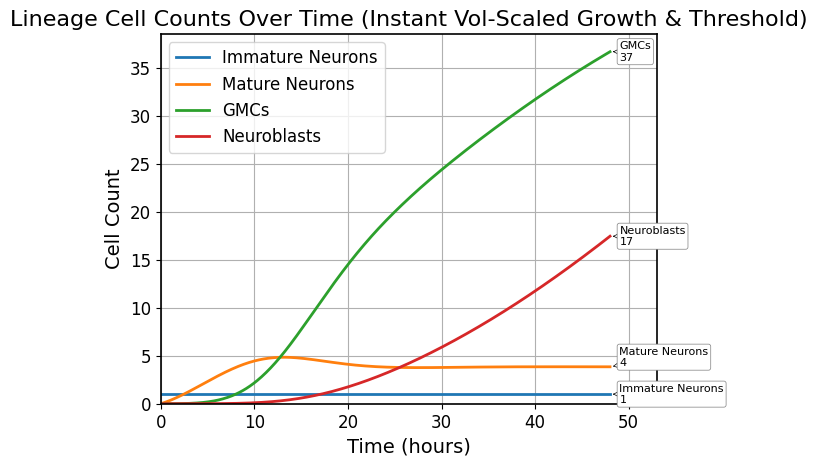

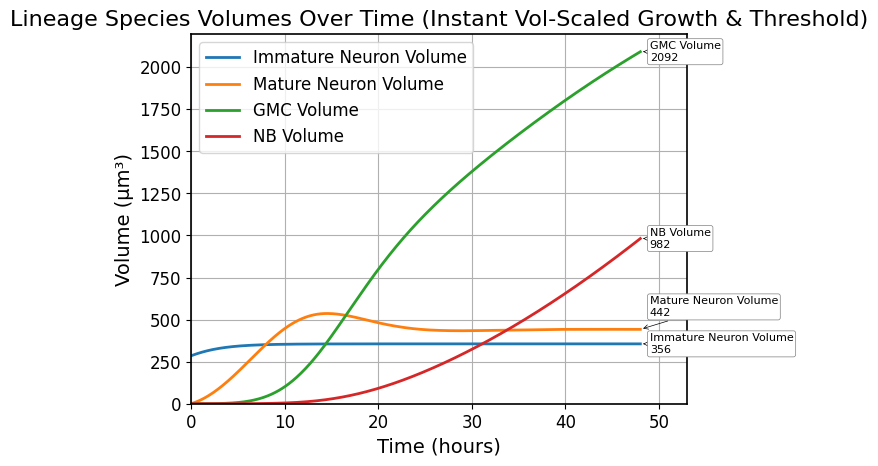

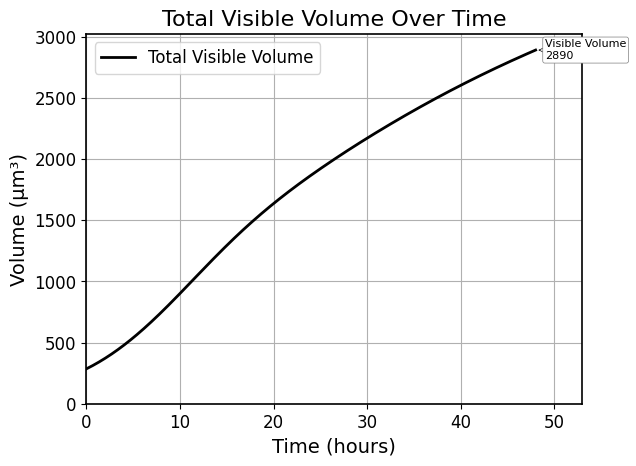

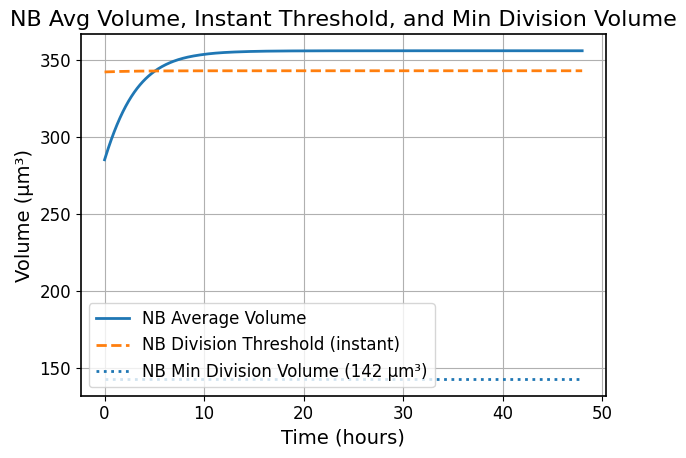

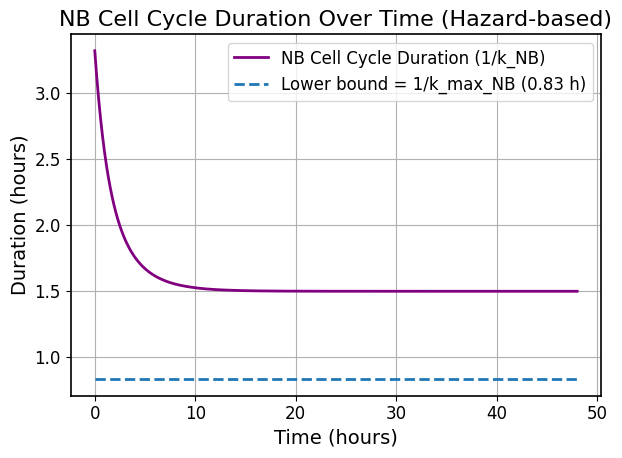

In [40]:
# --- WT params (instant volume-scaled growth and division threshold) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

V_thresh_base = 1.2 * nb_vol                # Base NB threshold at V_ref
g_NB_base = g_NB_base = nb_vol * 0.2 / 1.5  # NB base growth rate (volume/hr)
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr)

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³)
k_max_NB  = 1.2                             # Max NB division rate (divisions/hr)
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr)
n         = 6                               # Hill coefficient

sym_frac  = 0                               # Fraction of NB divisions that are symmetric
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr)
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume before division is allowed

# Instantaneous scaling parameters
V_ref         = nb_vol                      # Reference volume
alpha_growth  = 1                           # Growth sensitivity to NB volume
alpha_thresh  = 0.01                        # Threshold sensitivity to NB volume (much smaller)

# Parameter order:
# (g_NB_base, g_GMC, k_Neuron, sym_frac,
#  V_thresh_base, V_thresh_GMC,
#  k_max_NB, k_max_GMC, n,
#  V_floor_NB, V_ref, alpha_growth, alpha_thresh)
params_vol_scaled_instant = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_base, V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    V_floor_NB, V_ref,
    alpha_growth, alpha_thresh
]

# Initial conditions
# [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_vol_scaled = solve_ivp(
    neuroblast_model_vol_scaled_growth_and_threshold_instant,
    t_span, y0, t_eval=t_eval, args=(params_vol_scaled_instant,)
)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["Immature Neurons", "Mature Neurons", "GMCs", "Neuroblasts"]
indices = [0, 2, 4, 6]
y_data  = [sol_vol_scaled.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_vol_scaled.t, y, label=label)

ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("Lineage Cell Counts Over Time (Instant Vol-Scaled Growth & Threshold)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: Species total volumes ==========
fig, ax = plt.subplots()
labels_vol  = ["Immature Neuron Volume", "Mature Neuron Volume", "GMC Volume", "NB Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol  = [sol_vol_scaled.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_vol_scaled.t, y, label=label)

ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("Lineage Species Volumes Over Time (Instant Vol-Scaled Growth & Threshold)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 3: Total visible lineage volume ==========
fig, ax = plt.subplots()
total_visible_vol = sol_vol_scaled.y[1] + sol_vol_scaled.y[3] + sol_vol_scaled.y[5]
ax.plot(sol_vol_scaled.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("Total Visible Volume Over Time")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 4: NB avg volume vs instantaneous threshold (+ floor) ==========
Vavg_NB = np.divide(sol_vol_scaled.y[1], sol_vol_scaled.y[0],
                    out=np.zeros_like(sol_vol_scaled.y[1]),
                    where=sol_vol_scaled.y[0] > 0)

# Instantaneous threshold over time:
Vthresh_NB_t = V_thresh_base * (np.divide(Vavg_NB, V_ref,
                                          out=np.ones_like(Vavg_NB),
                                          where=V_ref > 0) ** alpha_thresh)

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_vol_scaled.t, Vthresh_NB_t, '--', label="NB Division Threshold (instant)")
ax.hlines(V_floor_NB, sol_vol_scaled.t[0], sol_vol_scaled.t[-1],
          linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Avg Volume, Instant Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ========== Plot 5: Cell cycle duration ==========
# Recompute Vavg and ratio (already in cell, but keep local for clarity)
Vavg_NB = np.divide(sol_vol_scaled.y[1], sol_vol_scaled.y[0],
                    out=np.zeros_like(sol_vol_scaled.y[1]),
                    where=sol_vol_scaled.y[0] > 0)
ratio = np.divide(Vavg_NB, V_ref, out=np.ones_like(Vavg_NB), where=V_ref > 0)

# Instant effective threshold series for NBs
V_thresh_eff_series = V_thresh_base * (ratio ** alpha_thresh)

# Instantaneous NB division rate from the same Hill form used in the ODE
with np.errstate(divide='ignore', invalid='ignore'):
    k_NB_series = np.where(
        Vavg_NB >= V_floor_NB,
        k_max_NB * (Vavg_NB**n) / (V_thresh_eff_series**n + Vavg_NB**n),
        0.0
    )

# Cell-cycle duration from division hazard (bounded by 1/k_max_NB)
ccd_hazard = np.where(k_NB_series > 0, 1.0 / k_NB_series, np.nan)

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, ccd_hazard, color="purple", label="NB Cell Cycle Duration (1/k_NB)")
ax.hlines(1.0 / k_max_NB, sol_vol_scaled.t[0], sol_vol_scaled.t[-1],
          linestyles="--", label=f"Lower bound = 1/k_max_NB ({1.0/k_max_NB:.2f} h)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Duration (hours)")
ax.set_title("NB Cell Cycle Duration Over Time (Hazard-based)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

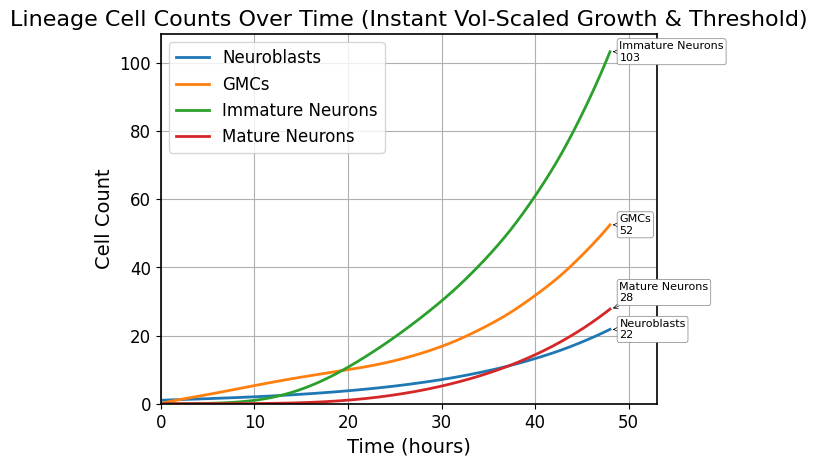

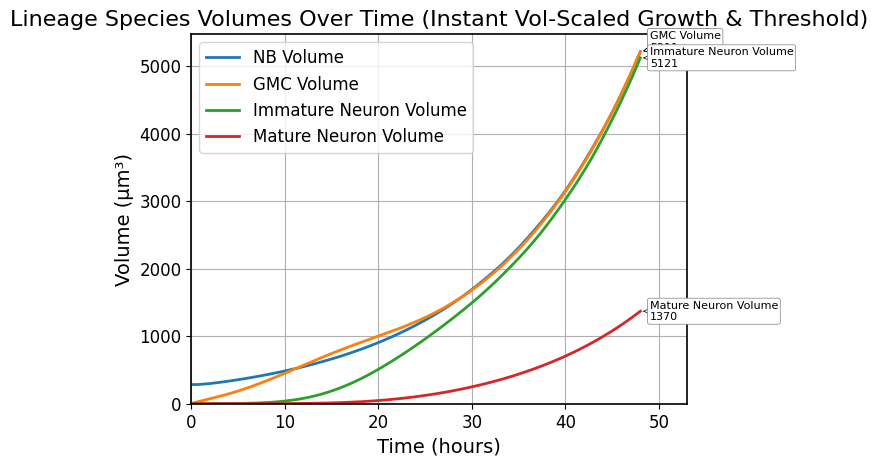

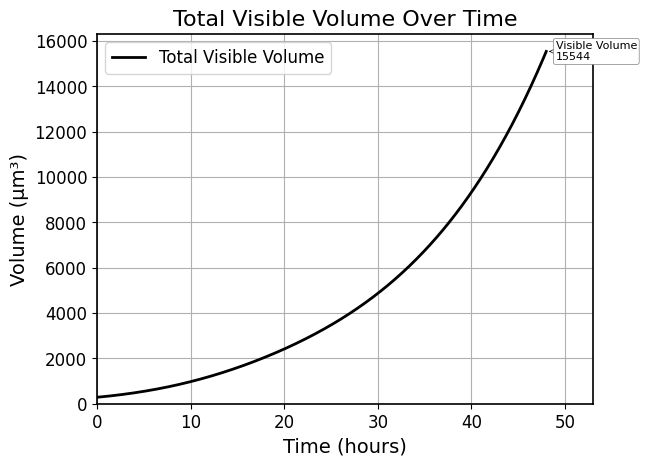

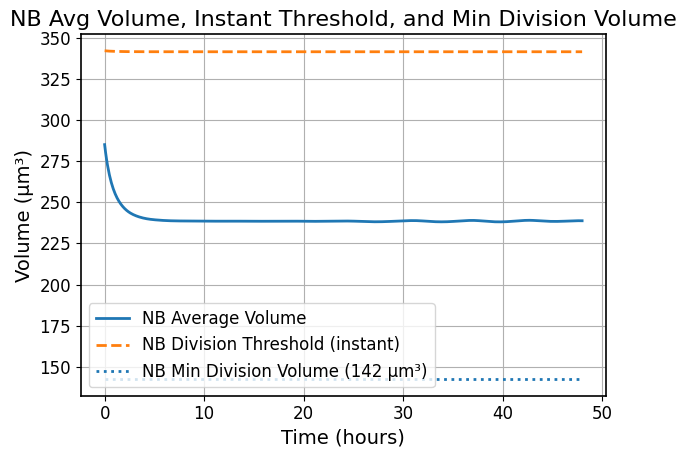

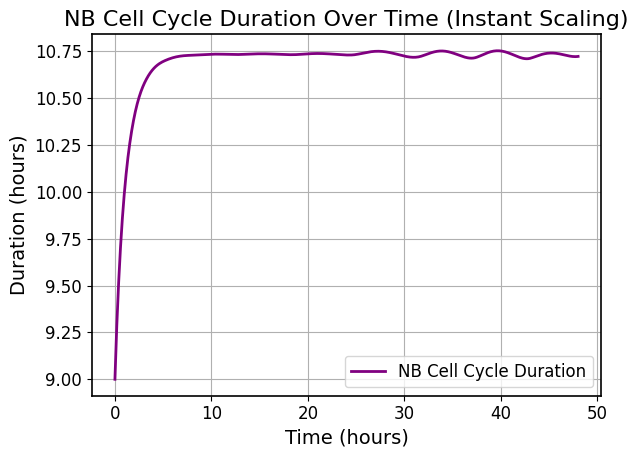

In [41]:
# --- mudmut params (instant volume-scaled growth and division threshold) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

g_NB_base = nb_vol * 0.2 / 1.5              # NB base growth rate (volume/hr)
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr)

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³)
k_max_NB  = 1 / 0.25                        # Max NB division rate (divisions/hr)
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr)
n         = 6                               # Hill coefficient

sym_frac  = 0.15                            # Fraction of NB divisions that are symmetric
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr)
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume before division is allowed

# Instantaneous scaling parameters
V_ref         = nb_vol                      # Reference volume
alpha_growth  = 1                           # Growth sensitivity to NB volume
alpha_thresh  = 0.01                        # Threshold sensitivity to NB volume (much smaller)
V_thresh_base = 1.2 * nb_vol                # Base NB threshold at V_ref

# Parameter order:
# (g_NB_base, g_GMC, k_Neuron, sym_frac,
#  V_thresh_base, V_thresh_GMC,
#  k_max_NB, k_max_GMC, n,
#  V_floor_NB, V_ref, alpha_growth, alpha_thresh)
params_vol_scaled_instant = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_base, V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    V_floor_NB, V_ref,
    alpha_growth, alpha_thresh
]

# Initial conditions
# [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_vol_scaled = solve_ivp(
    neuroblast_model_vol_scaled_growth_and_threshold_instant,
    t_span, y0, t_eval=t_eval, args=(params_vol_scaled_instant,)
)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data  = [sol_vol_scaled.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_vol_scaled.t, y, label=label)

ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("Lineage Cell Counts Over Time (Instant Vol-Scaled Growth & Threshold)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: Species total volumes ==========
fig, ax = plt.subplots()
labels_vol  = ["NB Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol  = [sol_vol_scaled.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol_vol_scaled.t, y, label=label)

ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, y_data_vol, labels_vol)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("Lineage Species Volumes Over Time (Instant Vol-Scaled Growth & Threshold)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 3: Total visible lineage volume ==========
fig, ax = plt.subplots()
total_visible_vol = sol_vol_scaled.y[1] + sol_vol_scaled.y[3] + sol_vol_scaled.y[5]
ax.plot(sol_vol_scaled.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, [total_visible_vol], ["Visible Volume"])
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("Total Visible Volume Over Time")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 4: NB avg volume vs instantaneous threshold (+ floor) ==========
Vavg_NB = np.divide(sol_vol_scaled.y[1], sol_vol_scaled.y[0],
                    out=np.zeros_like(sol_vol_scaled.y[1]),
                    where=sol_vol_scaled.y[0] > 0)

# Instantaneous threshold over time:
Vthresh_NB_t = V_thresh_base * (np.divide(Vavg_NB, V_ref,
                                          out=np.ones_like(Vavg_NB),
                                          where=V_ref > 0) ** alpha_thresh)

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_vol_scaled.t, Vthresh_NB_t, '--', label="NB Division Threshold (instant)")
ax.hlines(V_floor_NB, sol_vol_scaled.t[0], sol_vol_scaled.t[-1],
          linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Avg Volume, Instant Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ========== Plot 5: Cell cycle duration ==========
# g_eff(t) and V_thresh_eff(t) for the instant model:
vol_ratio = np.divide(Vavg_NB, V_ref, out=np.ones_like(Vavg_NB), where=V_ref > 0)
g_NB_eff_series = g_NB_base * (vol_ratio ** alpha_growth)
V_thresh_eff_series = V_thresh_base * (vol_ratio ** alpha_thresh)

with np.errstate(divide='ignore', invalid='ignore'):
    cell_cycle_duration = np.where(
        (g_NB_eff_series > 0),
        V_thresh_eff_series / g_NB_eff_series,
        np.nan
    )

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, cell_cycle_duration, color="purple", label="NB Cell Cycle Duration")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Duration (hours)")
ax.set_title("NB Cell Cycle Duration Over Time (Instant Scaling)")
ax.grid()
ax.legend()
if np.isnan(cell_cycle_duration).any():
    ax.fill_between(sol_vol_scaled.t, 0, np.nanmax(cell_cycle_duration),
                    where=np.isnan(cell_cycle_duration), color='red', alpha=0.2,
                    label="Undefined")
plt.tight_layout()
plt.show()